In [26]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost as xgb
from matplotlib import pyplot
import matplotlib.pyplot as mp
import warnings



%matplotlib inline





In [27]:
month_data = pd.read_csv('month_Data.csv')

In [28]:
month_data.head()

,amt_per_trans,cost,month_num,monthly_spent,num_offers,offer_id,person_id,profit,profity,trans_offer,...,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,target,quadrant
0,0.0,0.0,3.0,0.0,1.0,10.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
1,0.0,0.0,3.0,0.0,1.0,10.0,3.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
2,0.0,0.0,3.0,0.0,1.0,10.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
3,0.0,0.0,3.0,0.0,1.0,10.0,5.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
4,0.0,0.0,3.0,0.0,1.0,10.0,6.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3


In [29]:
month_data['year'] = month_data['month_num'] //2
month_data['quarters'] = month_data['month_num']//4



In [30]:
def monthoffer(offerid, month_data, start_month=2,\
                                end_month=19):
    """
    DESCRIPTION:
        Creating subset of monthly data for the offer
    
    INPUTS:
        offerid - Offer id we want to analyze
        month_data - The monthly data set that we loaded above
        start_month - First month of the data
        end_month - Last month of the data
    
    OUTPUTS:
        month_data_new - subset of original dataset for offer id we want to analyze
    """

    for month_num in range(start_month,end_month+1):
        # get the current month's data
        month_data_sub = month_data[month_data['month_num']==month_num]
        month_data_sub= month_data_sub[(month_data_sub[offerid]==1) |\
                                    (month_data_sub['offer_id_10']==1)]
        # get individuals who received the offer during the month
        month_ind = month_data_sub[month_data_sub[offerid]==1].person_id.unique()
        if month_num == start_month:
            month_data_new=month_data_sub[month_data_sub['person_id'].isin(month_ind)]
        else:
            month_data_new_2 = month_data_sub[month_data_sub['person_id'].isin(month_ind)]
            month_data_new = pd.concat([month_data_new, month_data_new_2], axis=0)
    month_data_new.reset_index(inplace=True)
    return month_data_new

In [31]:
month_data_4 = monthoffer('offer_id_4', month_data)

In [32]:
month_data_4.head()

,index,amt_per_trans,cost,month_num,monthly_spent,num_offers,offer_id,person_id,profit,profity,...,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,target,quadrant,year,quarters
0,29366,0.00,0.0,5.0,0.00,1.0,4.0,20.0,0.00,0.0,...,0,0,0,0,0,0,0,2,2.0,1.0
1,29367,1.13,0.0,5.0,1.13,1.0,10.0,20.0,1.13,1.0,...,0,0,0,0,0,1,0,1,2.0,1.0
2,29392,0.00,0.0,5.0,0.00,1.0,4.0,35.0,0.00,0.0,...,0,0,0,0,0,0,0,2,2.0,1.0
3,29393,0.00,0.0,5.0,0.00,1.0,10.0,35.0,0.00,0.0,...,0,0,0,0,0,1,0,3,2.0,1.0
4,29394,0.00,0.0,5.0,0.00,1.0,4.0,36.0,0.00,0.0,...,0,0,0,0,0,0,0,2,2.0,1.0


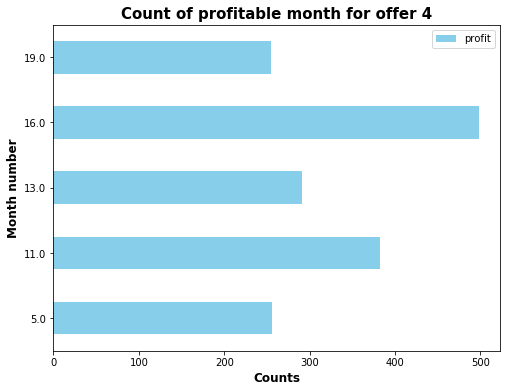

In [33]:
fig, ax = mp.subplots(figsize=(8,6));
month_data_4[month_data_4['offer_id_4']==1].groupby('month_num').agg({'profit':'sum'}).reset_index().plot(x='month_num', y='profit', kind='barh',  color = 'skyblue',ax=ax);
ax.set_title("Count of profitable month for offer 4", fontsize=15, weight = 'bold')
ax.set_xlabel("Counts", fontsize=12 , weight = 'bold') ;
ax.set_ylabel("Month number", fontsize=12 , weight = 'bold');
ax.tick_params(axis='both', which='major', labelsize=10);

##https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller

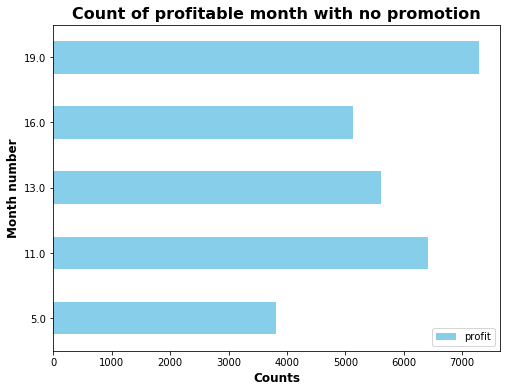

In [34]:
fig, ax = mp.subplots(figsize=(8,6));
month_data_4[month_data_4['offer_id_4']==0].groupby('month_num').agg({'profit':'sum'}).reset_index().plot(x='month_num', y='profit', kind='barh', color = 'skyblue',ax=ax);
ax.set_title("Count of profitable month with no promotion", fontsize=16, weight = 'bold')
ax.set_xlabel("Counts", fontsize=12 , weight = 'bold') ;
ax.set_ylabel("Month number", fontsize=12 , weight = 'bold');
ax.tick_params(axis='both', which='major', labelsize=10);


In [35]:
month_data_4.month_num.value_counts().sort_index()

5.0     2480
11.0    2560
13.0    2616
16.0    2620
19.0    2474
Name: month_num, dtype: int64

In [36]:


train_offer_4 = month_data_4[month_data_4['month_num']<=13].reset_index(drop=True)
valid_offer_4 = month_data_4[month_data_4['month_num']==16].reset_index(drop=True)
test_offer_4 = month_data_4[month_data_4['month_num']==19].reset_index(drop=True)

#### Model

In [37]:
features = list(month_data.columns)
month_data.head()

,amt_per_trans,cost,month_num,monthly_spent,num_offers,offer_id,person_id,profit,profity,trans_offer,...,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,target,quadrant,year,quarters
0,0.0,0.0,3.0,0.0,1.0,10.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,3,1.0,0.0
1,0.0,0.0,3.0,0.0,1.0,10.0,3.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,3,1.0,0.0
2,0.0,0.0,3.0,0.0,1.0,10.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,3,1.0,0.0
3,0.0,0.0,3.0,0.0,1.0,10.0,5.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,3,1.0,0.0
4,0.0,0.0,3.0,0.0,1.0,10.0,6.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,3,1.0,0.0


In [38]:
features =['amt_per_trans',
 'cost',
 'month_num',
 'monthly_spent',
 'num_offers',
 'profit',
 'profity',
 'trans_offer',
 'cum_monthly_spent_offer_id_0',
 'cum_trans_offer_offer_id_0',
 'cum_profit_offer_id_0',
 'cum_monthly_spent_offer_id_1',
 'cum_trans_offer_offer_id_1',
 'cum_profit_offer_id_1',
 'cum_monthly_spent_offer_id_2',
 'cum_trans_offer_offer_id_2',
 'cum_profit_offer_id_2',
 'cum_monthly_spent_offer_id_3',
 'cum_trans_offer_offer_id_3',
 'cum_profit_offer_id_3',
 'cum_monthly_spent_offer_id_4',
 'cum_trans_offer_offer_id_4',
 'cum_profit_offer_id_4',
 'cum_monthly_spent_offer_id_5',
 'cum_trans_offer_offer_id_5',
 'cum_profit_offer_id_5',
 'cum_monthly_spent_offer_id_6',
 'cum_trans_offer_offer_id_6',
 'cum_profit_offer_id_6',
 'cum_monthly_spent_offer_id_7',
 'cum_trans_offer_offer_id_7',
 'cum_profit_offer_id_7',
 'cum_monthly_spent_offer_id_8',
 'cum_trans_offer_offer_id_8',
 'cum_profit_offer_id_8',
 'cum_monthly_spent_offer_id_9',
 'cum_trans_offer_offer_id_9',
 'cum_profit_offer_id_9',
 'cum_monthly_spent_offer_id_10',
 'cum_trans_offer_offer_id_10',
 'cum_profit_offer_id_10',
 'cum_spent_per_trans_offer_offer_id_0',
 'cum_spent_per_trans_offer_offer_id_1',
 'cum_spent_per_trans_offer_offer_id_2',
 'cum_spent_per_trans_offer_offer_id_3',
 'cum_spent_per_trans_offer_offer_id_4',
 'cum_spent_per_trans_offer_offer_id_5',
 'cum_spent_per_trans_offer_offer_id_6',
 'cum_spent_per_trans_offer_offer_id_7',
 'cum_spent_per_trans_offer_offer_id_8',
 'cum_spent_per_trans_offer_offer_id_9',
 'cum_spent_per_trans_offer_offer_id_10',
 'cum_profit_per_trans_offer_offer_id_0',
 'cum_profit_per_trans_offer_offer_id_1',
 'cum_profit_per_trans_offer_offer_id_2',
 'cum_profit_per_trans_offer_offer_id_3',
 'cum_profit_per_trans_offer_offer_id_4',
 'cum_profit_per_trans_offer_offer_id_5',
 'cum_profit_per_trans_offer_offer_id_6',
 'cum_profit_per_trans_offer_offer_id_7',
 'cum_profit_per_trans_offer_offer_id_8',
 'cum_profit_per_trans_offer_offer_id_9',
 'cum_profit_per_trans_offer_offer_id_10',
 'cum_total_spend',
 'cum_trans',
 'cum_profit',
 'age',
 'income',
 'year_of_member',
 'month_of_member',
 'day_of_member',
 'gender_F',
 'gender_M',
 'gender_O',
 'year',
 'quarters']

In [39]:

X_train_offer_4 = train_offer_4[features]
X_valid_offer_4 = valid_offer_4[features]
X_test_offer_4 = test_offer_4[features]

Y_train_offer_4 = train_offer_4.profit
Y_valid_offer_4 = valid_offer_4.profit
Y_test_offer_4 = test_offer_4.profit

In [40]:
X_valid_offer_4

,amt_per_trans,cost,month_num,monthly_spent,num_offers,profit,profity,trans_offer,cum_monthly_spent_offer_id_0,cum_trans_offer_offer_id_0,...,age,income,year_of_member,month_of_member,day_of_member,gender_F,gender_M,gender_O,year,quarters
0,0.000,0.0,16.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,...,24.000000,42000.000000,2017,9,10,0,1,0,8.0,4.0
1,0.000,0.0,16.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,...,24.000000,42000.000000,2017,9,10,0,1,0,8.0,4.0
2,0.000,0.0,16.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,...,57.000000,116000.000000,2015,11,19,1,0,0,8.0,4.0
3,0.000,0.0,16.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,...,57.000000,116000.000000,2015,11,19,1,0,0,8.0,4.0
4,0.000,0.0,16.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,...,27.000000,39000.000000,2018,7,10,0,1,0,8.0,4.0
5,0.000,0.0,16.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,...,27.000000,39000.000000,2018,7,10,0,1,0,8.0,4.0
6,0.000,0.0,16.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,...,51.582920,64760.199219,2016,2,24,0,1,0,8.0,4.0
7,0.000,0.0,16.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,...,51.582920,64760.199219,2016,2,24,0,1,0,8.0,4.0
8,0.000,0.0,16.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,...,70.000000,64000.000000,2016,3,20,0,1,0,8.0,4.0
9,11.995,0.0,16.0,23.99,1.0,23.99,1.0,2.0,0.0,0.0,...,70.000000,64000.000000,2016,3,20,0,1,0,8.0,4.0


In [41]:
ss = StandardScaler()
X_train_scaled_offer_4 = pd.DataFrame(ss.fit_transform(X_train_offer_4))
X_train_scaled_offer_4.columns = features
X_train_scaled_offer_4.index = X_train_offer_4.index

X_valid_scaled_offer_4 = pd.DataFrame(ss.transform(X_valid_offer_4))
X_valid_scaled_offer_4.columns = features
X_valid_scaled_offer_4.index = X_valid_offer_4.index

X_test_scaled_offer_4 = pd.DataFrame(ss.transform(X_test_offer_4))
X_test_scaled_offer_4.columns = features
X_test_scaled_offer_4.index = X_test_offer_4.index

In [42]:
def PCAp(df, comp=None):
    '''
    DESCRIPTION:
       Purpose of this function is to transform the data into priciple components and provide back the data frame with PCA components

    INPUTS:
        df - data frame that we would need to transform
        comp - principle components

    OUTPUTS: 
        pca - the pca object created after fitting the data
        X_pca - the transformed X matrix with new number of components
    '''
    
    
    pca = PCA(comp)
    X_pca = pd.DataFrame(pca.fit_transform(df))
    if comp != None:
        X_pca.columns = ["pca_comp_n_" + str(i) for i in range(comp)]
    X_pca.index = df.index
    
    return pca, X_pca

## Same function was used in data processing 1

Text(0.5,1,'Explained Variance vs number of Principal Component')

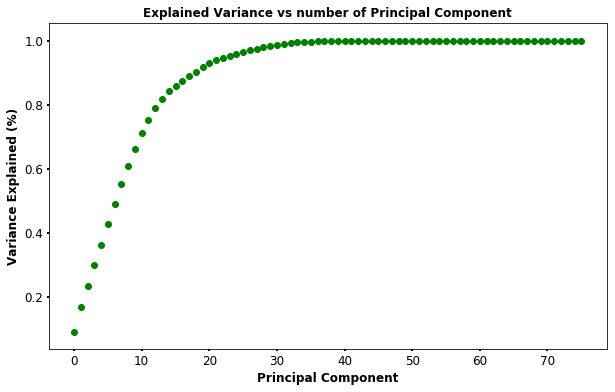

In [43]:
pca, X_train_pca_offer_4 = PCAp(X_train_scaled_offer_4, comp=None)

val = pca.explained_variance_ratio_

ind = np.arange(len(val))

val = val [:len(val)]
mp.figure(figsize=(10,6))
ax = mp.subplot(111)
    # Create array of cumulative variance explained for each n^th component
cumulative_values = np.cumsum(val)
    
# Plot line chart of cumulative variance explained vs number of components
ax.scatter(ind, cumulative_values, color = 'green')
ax.xaxis.set_tick_params(width=2, length=2, labelsize = '12')
ax.yaxis.set_tick_params(width=2, length=2, labelsize = '12')
ax.set_xlabel("Principal Component", fontsize = 12, weight = 'bold')
ax.set_ylabel("Variance Explained (%)", fontsize = 12, weight = 'bold')
mp.title('Explained Variance vs number of Principal Component', fontsize = 12, weight = 'bold')
    

##### n comp = 30 should satisfy

In [44]:
n_components = 30
values = pca.explained_variance_ratio_
cumulative_values = np.cumsum(values)
print("With {} components, {:.4f}% of the variance is explained".format(n_components, cumulative_values[n_components -1]*100))

With 30 components, 98.3919% of the variance is explained


In [45]:
comp = 30
pca, X_train_pca_offer_4 = PCAp(X_train_scaled_offer_4, comp=comp)

X_train_pca_offer_4.head()

,pca_comp_n_0,pca_comp_n_1,pca_comp_n_2,pca_comp_n_3,pca_comp_n_4,pca_comp_n_5,pca_comp_n_6,pca_comp_n_7,pca_comp_n_8,pca_comp_n_9,...,pca_comp_n_20,pca_comp_n_21,pca_comp_n_22,pca_comp_n_23,pca_comp_n_24,pca_comp_n_25,pca_comp_n_26,pca_comp_n_27,pca_comp_n_28,pca_comp_n_29
0,-2.138414,0.689570,0.083293,-0.164931,0.009179,-0.093563,-0.071978,-0.123100,0.473447,-0.070007,...,-0.209047,-0.180229,-0.098907,0.049873,0.010382,0.026401,-0.058118,0.017564,-0.004276,0.015225
1,-1.903835,0.549458,-0.018507,-0.214432,-0.102383,-0.009720,-0.035905,-0.187451,0.140136,-0.415523,...,-1.276203,-0.292777,-0.336457,0.027723,0.018035,0.008751,-0.040210,0.013921,-0.016401,0.014549
2,-1.276718,0.293229,-0.094268,-0.245322,-0.045997,-0.105937,-0.064230,0.018489,-0.060264,-0.157328,...,-0.423666,0.027952,-1.297814,0.747279,0.015868,0.191489,-0.150717,-0.035762,-0.021666,0.007979
3,-1.276718,0.293229,-0.094268,-0.245322,-0.045997,-0.105937,-0.064230,0.018489,-0.060264,-0.157328,...,-0.423666,0.027952,-1.297814,0.747279,0.015868,0.191489,-0.150717,-0.035762,-0.021666,0.007979
4,-2.562475,0.869060,0.082957,-0.078925,0.014130,-0.113169,-0.138609,-0.203221,0.623101,0.013180,...,0.486794,-0.818079,-0.371298,-0.178065,0.007730,-0.059015,0.138039,-0.093581,0.021855,0.046295


In [46]:
X_valid_pca_offer_4 = pd.DataFrame(pca.transform(X_valid_scaled_offer_4))
X_valid_pca_offer_4.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_valid_pca_offer_4.index = X_valid_scaled_offer_4.index

X_test_pca_offer_4 = pd.DataFrame(pca.transform(X_test_scaled_offer_4))
X_test_pca_offer_4.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_test_pca_offer_4.index = X_test_scaled_offer_4.index

In [48]:
train_ind_offer_4 = train_offer_4['offer_id_0']
valid_ind_offer_4 = valid_offer_4['offer_id_0']
test_ind_offer_4 = test_offer_4['offer_id_0']

X_train_pca_offer_4 = pd.concat([X_train_pca_offer_4, train_ind_offer_4], axis=1)
X_valid_pca_offer_4 = pd.concat([X_valid_pca_offer_4, valid_ind_offer_4], axis=1)
X_test_pca_offer_4 = pd.concat([X_test_pca_offer_4, test_ind_offer_4], axis=1)